#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 분류 머신러닝 모델
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# 딥러닝
from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, SimpleRNN, LSTM, concatenate
from keras.optimizers import Adam

# 분류 평가 지표
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# 검증, 하이퍼 파라미터 튜닝
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split




* 함수 생성

In [10]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [2]:
import joblib
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
project_path = '/content/drive/MyDrive/미니 프로젝트/'
# top data
# data = joblib.load(project_path+'top_data.pkl')
# 일반 데이터
features = joblib.load(project_path+'features_df.pkl')
data = pd.read_csv(project_path+'data01_train.csv')
# data_test = pd.read_csv(project_path+'data01_test.csv')

#### 2) 기본 정보 조회

In [13]:
data.shape, data_test.shape

((5881, 563), (1471, 563))

In [14]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [16]:
target = 'Activity'

x = data.drop(target, axis=1)
y = data.loc[:, target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

((5881, 562), (5881,), (1471, 562))

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : LinearRegression

In [25]:
y_train.unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [28]:
# y_train_copy = y_train.copy()
y_train = y_train.map({'STANDING':0,
             'LAYING':1,
             'WALKING':2,
             'WALKING_DOWNSTAIRS':3,
             'WALKING_UPSTAIRS':4,
             'SITTING':5})
y_train

0       0
1       1
2       0
3       2
4       3
       ..
5876    5
5877    4
5878    1
5879    4
5880    5
Name: Activity, Length: 5881, dtype: int64

In [51]:
model = LinearRegression()
cv_score = cross_val_score(model, x_train, y_train, cv=10)

In [52]:
cv_score.mean()

0.7050329945818846

In [207]:
def get_cv_score(name, model, score_name, cv=10):
  cv_score = cross_val_score(model, x_train, y_train, cv=cv, verbose=0)
  result.loc[result['name']==name, score_name] = cv_score.mean()
  print(f'{name} cv score : ',cv_score.mean())

In [ ]:
result = pd.DataFrame({})
result['name'] = ['LR', 'KNN', 'DT', 'RF', 'XGB', 'LGBM', 'SVM']
result['cv_score_all'] = 0

In [54]:
name='LR'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.7050329945818846


### (2) 알고리즘2 : KNN

In [55]:
model = KNeighborsClassifier()
name='KNN'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.9665012184839981


### (3) 알고리즘3 : DT

In [57]:
model = DecisionTreeClassifier(max_depth=5)
name = 'DT'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.9039271566011804


### (4) 알고리즘4 : RF

---



In [58]:
model = RandomForestClassifier(max_depth=5)
name = 'RF'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.9358956146125681


### (5) xgb

In [65]:
model = XGBClassifier(max_depth=5)
name = 'XGB'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.8905230725336633


###(6) LGBM

In [67]:
model = LGBMClassifier(max_depth=5, verbose=-1)
name = 'LGBM'
get_cv_score(name, model, score_name='cv_score_all')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140163
[LightGBM] [Info] Number of data points in the train set: 5292, number of used features: 562
[LightGBM] [Info] Start training from score 2.393235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

(7) SVM

In [70]:
model = SVC(kernel ='linear')
name = 'SVM'
get_cv_score(name, model, score_name='cv_score_all')

cv score mean :  0.9855476825704816


###(8) 딥러닝

In [117]:
from keras.regularizers import l1, l2
clear_session()
intensity = 0.001
model = Sequential([Dense(256, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer = l1(intensity)),
                    Dense(128, activation='relu',kernel_regularizer = l1(intensity)),
                    Dense(64, activation='relu',kernel_regularizer = l1(intensity)),
                    Dense(32, activation='relu',kernel_regularizer = l1(intensity)),
                    Dense(16, activation='relu',kernel_regularizer = l1(intensity)),
                    Dense(6, activation='softmax')
                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               144128    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 6)                 102       
                                                                 
Total params: 187990 (734.34 KB)
Trainable params: 18799

In [118]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy')

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta = 0.02, patience=10)
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es]).history

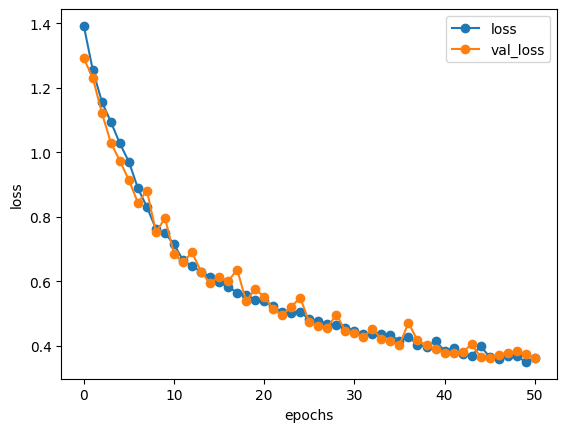

In [119]:
def history_plot(history):
  plt.plot(history['loss'][3:], label='loss', marker='o')
  plt.plot(history['val_loss'][3:], label='val_loss', marker='o')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
history_plot(history)

In [133]:
  y_pred = model.predict(x_test)
  y_pred

46/46 [==============================] - 0s 4ms/step


array([[1.1676107e-02, 1.2009592e-05, 5.5604087e-08, 6.5027768e-07,
        9.6809548e-05, 9.8821431e-01],
       [9.7807693e-01, 2.2786512e-06, 6.9045062e-05, 9.8056333e-08,
        2.6083353e-05, 2.1825407e-02],
       [8.2009187e-04, 3.9654475e-07, 9.9896455e-01, 1.2993750e-04,
        8.4213709e-05, 8.6836150e-07],
       ...,
       [9.1576361e-04, 6.0015963e-04, 2.6450491e-01, 7.3208153e-01,
        1.7311445e-03, 1.6659038e-04],
       [5.7162692e-09, 9.9956948e-01, 3.8139266e-12, 3.3559478e-05,
        1.5401959e-12, 3.9688579e-04],
       [1.9115007e-06, 1.5784837e-03, 3.3213510e-05, 9.9825591e-01,
        4.9150189e-05, 8.1333041e-05]], dtype=float32)

In [134]:
# 최대 값을 찾자
y_test = y_test.map({'STANDING':0,
             'LAYING':1,
             'WALKING':2,
             'WALKING_DOWNSTAIRS':3,
             'WALKING_UPSTAIRS':4,
             'SITTING':5})
y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[261   0   0   0   0  26]
 [  0 292   0   0   0   0]
 [  1   0 226   0   1   0]
 [  0   0   5 184   6   0]
 [  1   0   3   0 211   0]
 [ 14   0   0   0   0 240]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       287
           1       1.00      1.00      1.00       292
           2       0.97      0.99      0.98       228
           3       1.00      0.94      0.97       195
           4       0.97      0.98      0.97       215
           5       0.90      0.94      0.92       254

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



In [159]:
new_row = pd.DataFrame({'name':['DL'], 'cv_score_all': [accuracy_score(y_test, y_pred)]})
result = pd.concat([result,new_row], axis=0)
result

,name,cv_score_all,accuracy
0,LR,0.705033,0.000000
1,KNN,0.966501,0.000000
2,DT,0.903927,0.000000
3,RF,0.935896,0.000000
4,XGB,0.890523,0.000000
5,LGBM,0.895110,0.000000
6,SVM,0.985548,0.000000
0,DL,0.000000,0.961251


In [173]:
temp = list()
temp += ['dsf']
temp

['dsf']

In [197]:
top_feature = list(features.sort_values(by='activity_importance', ascending=False)[:100]['feature_name'].values)
top_feature.append('Activity')
data.loc[:, top_feature]


,tGravityAcc-mean()-X,"angle(X,gravityMean)",tGravityAcc-energy()-X,tGravityAcc-mean()-Y,tGravityAcc-min()-X,"angle(Y,gravityMean)",tGravityAcc-min()-Y,tGravityAcc-max()-X,tGravityAcc-energy()-Y,tBodyAccJerk-std()-X,...,tBodyAccMag-max(),tBodyAccJerk-energy()-X,"fBodyAccJerk-bandsEnergy()-1,24.2","fBodyAccJerk-bandsEnergy()-1,24.1",tBodyAccJerkMag-std(),tBodyAccJerk-iqr()-Y,fBodyAccJerk-energy()-Y,tGravityAccMag-energy(),tBodyGyroJerk-mad()-Z,Activity
0,0.875254,-0.601120,0.673768,-0.358842,0.891969,0.331298,-0.334921,0.805627,-0.775936,-0.987135,...,-0.975728,-0.999830,-0.999688,-0.999708,-0.990259,-0.979984,-0.999720,-0.999395,-0.985623,STANDING
1,-0.134711,0.345205,-0.893830,0.924656,-0.095343,-0.769186,0.937432,-0.200892,0.714508,-0.990694,...,-0.989955,-0.999893,-0.999636,-0.999908,-0.992346,-0.990136,-0.999892,-0.999816,-0.990121,LAYING
2,0.965965,-0.833564,0.906252,-0.174095,0.985606,0.202434,-0.145801,0.891615,-0.953043,-0.994537,...,-0.991692,-0.999948,-0.999787,-0.999491,-0.988836,-0.976296,-0.999429,-0.999913,-0.990426,STANDING
3,0.927343,-0.695819,0.805419,-0.297703,0.943954,0.287154,-0.275699,0.858160,-0.849096,-0.240408,...,-0.258592,-0.708350,-0.814915,-0.678856,-0.291206,-0.188099,-0.674814,-0.619476,-0.419305,WALKING
4,0.901125,-0.705029,0.738738,-0.260540,0.901943,0.264952,-0.263482,0.858531,-0.885215,-0.147723,...,0.160197,-0.633311,-0.942707,-0.804809,-0.235142,-0.576064,-0.836659,-0.404608,-0.634217,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.973223,-0.912365,0.925506,-0.044093,0.992398,0.114009,-0.027374,0.899036,-0.998616,-0.991070,...,-0.963586,-0.999899,-0.999627,-0.999691,-0.989238,-0.980777,-0.999656,-0.998172,-0.986515,SITTING
5877,0.910932,-0.690278,0.763412,-0.317517,0.921001,0.303194,-0.291398,0.843681,-0.826961,-0.269783,...,-0.202945,-0.730615,-0.955215,-0.667505,-0.400074,-0.122426,-0.701001,-0.574805,-0.677284,WALKING_UPSTAIRS
5878,-0.514220,0.620363,-0.998561,0.684910,-0.465011,-0.437247,0.700942,-0.579367,-0.046641,-0.985539,...,-0.986655,-0.999797,-0.999815,-0.999821,-0.991058,-0.985324,-0.999763,-0.999881,-0.993142,LAYING
5879,0.921553,-0.718009,0.790552,-0.302780,0.932387,0.292856,-0.293450,0.852565,-0.843467,-0.207507,...,-0.141070,-0.683215,-0.958866,-0.650324,-0.297046,-0.382279,-0.723597,-0.514370,-0.342907,WALKING_UPSTAIRS


In [204]:
def top_data(top_num, data, data_test):
  # 상위 데이터
  top_feature = list(features.sort_values(by='activity_importance', ascending=False)[:100]['feature_name'].values)
  top_feature.append('Activity')
  data = data.loc[:, top_feature]
  data_test = data_test.loc[:, top_feature]
  print(f'train data shape :{data.shape}, test data shape : {data_test.shape}')

  # 데이터 전처리
  target = 'Activity'
  x_train = data.drop(target, axis=1)
  y_train = data.loc[:, target]
  x_test = data_test.drop(target, axis=1)
  y_test = data_test.loc[:, target]

  # 스케일링
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  # 정수 encoding
  y_train = y_train.map({'STANDING':0,
             'LAYING':1,
             'WALKING':2,
             'WALKING_DOWNSTAIRS':3,
             'WALKING_UPSTAIRS':4,
             'SITTING':5})
  y_test = y_test.map({'STANDING':0,
             'LAYING':1,
             'WALKING':2,
             'WALKING_DOWNSTAIRS':3,
             'WALKING_UPSTAIRS':4,
             'SITTING':5})
  score_name = 'cv_score_100'
  result.loc[:,score_name] = 0
  # LR
  name='LR'
  model = LinearRegression()
  get_cv_score(name, model, score_name=score_name)
  # KNN
  name='KNN'
  model = KNeighborsClassifier()
  get_cv_score(name, model, score_name=score_name)
  # DT
  name='DT'
  model = DecisionTreeClassifier(max_depth=5)
  get_cv_score(name, model, score_name=score_name)
  # RF
  name='RF'
  model = RandomForestClassifier(max_depth=5)
  get_cv_score(name, model, score_name=score_name)
  # XGB
  name='XGB'
  model = XGBClassifier(max_depth=5)
  get_cv_score(name, model, score_name=score_name)
  # LGBM
  name='LGBM'
  model = LGBMClassifier(max_depth=5)
  get_cv_score(name, model, score_name=score_name)
  # SVM
  name='SVM'
  model = SVC(kernel='linear')
  get_cv_score(name, model, score_name=score_name)
  # DL
  name='DL'
  clear_session()
  intensity = 0.001
  model = Sequential([Dense(256, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer = l1(intensity)),
                      Dense(128, activation='relu',kernel_regularizer = l1(intensity)),
                      Dense(64, activation='relu',kernel_regularizer = l1(intensity)),
                      Dense(32, activation='relu',kernel_regularizer = l1(intensity)),
                      Dense(16, activation='relu',kernel_regularizer = l1(intensity)),
                      Dense(6, activation='softmax')
                      ])
  model.summary()
  model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy')
  es = EarlyStopping(monitor='val_loss', min_delta = 0.02, patience=10)
  history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[es]).history
  history_plot(history)
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

  result.loc[result['name']==name,score_name] = accuracy_score(y_test, y_pred)
  display(result)

In [205]:
data_c = data.copy()
data_t_c = data_test.copy()
top_data(100, data_c, data_t_c) # 상위 100개 데이터 반복


train data shape :(5881, 101), test data shape : (1471, 101)


<ipython-input-204-7aa33a88c62d>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.loc[:,score_name] = 0
<ipython-input-204-7aa33a88c62d>:35: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:,score_name] = 0


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [215]:
result

,name,cv_score_all,cv_score_100
0,LR,0.705033,0.705033
1,KNN,0.966501,0.966501
2,DT,0.903927,0.903757
3,RF,0.935896,0.938956
4,XGB,0.890523,0.992519
5,LGBM,0.895110,0.993029
6,SVM,0.985548,0.985548
0,DL,0.961251,0.000000
